# Final Project Machine Learning 
## Classification of Political Bias Presence in Social Media
- Joe Cruz 
- 28Aug2020

 

This script is designed to generate learning models for the dataset found in the Political-media-DFE.csv. The purpose of these learning models are to perform classification of text data from social media (Twitter and Facebook) and determine whether or not they have a poltiical bias (either neutral or partisan). The learning models used in this script are as follows: Multinomial Naive Bayes, LinearSVC, and Logistic Regression.

The name of the dataset used is called Classification of Pol Social, where the file name of the dataset is called
Political-media-DFE.csv. The dataset can be found at https://data.world/crowdflower/classification-of-pol-social



## Required Imports

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pickle




## Cleaning the dataset

In [2]:
#defining the preprocessor function for cleaning up the text from the data sheet
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [3]:
#create instance of object to hold data, pulls data from the 'bias' and 'text' columns in the data sheet
posts = pd.read_csv('Political-media-DFE.csv',encoding='latin1')[['bias','text']]

In [4]:
#names columns 'bias' and 'text'
posts.columns = ['bias','text']
posts = posts.reset_index(drop=True)

# Clean tweet text of HTML, etc.
posts['cleaned_text'] = posts.text.map(preprocessor)

# object is printed to view current status of the object, as we currently have 3 columns: 'bias', 'text', and 'cleaned_text'.
print(posts)

          bias                                               text  \
0     partisan  RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...   
1     partisan  VIDEO - #Obamacare:  Full of Higher Costs and ...   
2      neutral  Please join me today in remembering our fallen...   
3      neutral  RT @SenatorLeahy: 1st step toward Senate debat...   
4     partisan  .@amazon delivery #drones show need to update ...   
...        ...                                                ...   
4995  partisan  I applaud Governor PerryÛªs recent decision t...   
4996  partisan  Today, I voted in favor of H.R. 5016 - Financi...   
4997   neutral  (Taken from posted WOKV interview)   Congressm...   
4998   neutral  Join me next week for a town hall in Ocala! I'...   
4999   neutral  Foreign Affairs Committee Hearing on Syria. I ...   

                                           cleaned_text  
0     rt nowthisnews rep trey radel r fl slams obama...  
1     video obamacare full of higher costs and broke...

In [5]:
#Creating another object for creating the class analysis
dataset= posts

In [6]:
# Checking whether there are any null data points in the data set that is being imported to the data object. Luckily there 
#are no null values
dataset.isnull().sum()

bias            0
text            0
cleaned_text    0
dtype: int64

neutral     3689
partisan    1311
Name: bias, dtype: int64


Text(0.5, 1.0, 'Class Analysis: \nSample Data Distribution')

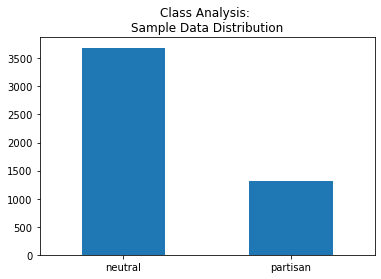

In [7]:
#Generating a bar graph to symbolize the class analysis (number of data points in the dataset associated with each class)
#Since this is a binary classification, the two classes are neutral or partisan.
dataset.columns
print(dataset['bias'].value_counts())
figure=dataset['bias'].value_counts().plot(kind='bar', rot=0)
figure.set_title('Class Analysis: \nSample Data Distribution')

In [8]:
# removes the original text column from the object. Since we now have a cleaned text, it is best to remove the column and ensure
#our object only holds the values of data we need to use.
posts.drop(columns = ['text'],axis =1, inplace=True)

# object is printed to view current status of the object, as we currently have 2 columns: 'bias'  and 'cleaned_text'.
print(posts)

          bias                                       cleaned_text
0     partisan  rt nowthisnews rep trey radel r fl slams obama...
1     partisan  video obamacare full of higher costs and broke...
2      neutral  please join me today in remembering our fallen...
3      neutral  rt senatorleahy 1st step toward senate debate ...
4     partisan   amazon delivery drones show need to update la...
...        ...                                                ...
4995  partisan  i applaud governor perry ûªs recent decision t...
4996  partisan  today i voted in favor of h r 5016 financial s...
4997   neutral   taken from posted wokv interview congressman ...
4998   neutral  join me next week for a town hall in ocala i l...
4999   neutral  foreign affairs committee hearing on syria i r...

[5000 rows x 2 columns]


In [9]:
# Reindex randomly
posts = posts.reindex(index=np.random.permutation(posts.index))

# object is printed to view current status of the object.
# The indexes are now random instead of sequential.
print(posts)

          bias                                       cleaned_text
3294   neutral  it was great seeing you ryan davenport thank y...
7      neutral  show your arizona pride choose your favorite s...
3666   neutral  kode ksn reported on my local business tour in...
771    neutral  getting my bubba watson on this am wafflehouse...
352    neutral  rt md_dlds at the jobs forum featuring the us ...
...        ...                                                ...
1810   neutral  with john warner timkaine for shipyard keel la...
2741  partisan  ben commonsense laws concerning things as powe...
1416   neutral  no child should be held back due to zip codes ...
4756   neutral  with steel salvaged from the twin towers forge...
4471  partisan  if my constituents must suffer through the per...

[5000 rows x 2 columns]


In [10]:
#imports the stopwords from ntlk.corpus and the alphabet 
#These 5 lines are for creating the stop word list that we need to create the lemmas for analysis
#these remove common words that may not be necessary for our classification (ie a, the, etc)
from nltk.corpus import stopwords
from string import ascii_lowercase as alphabet

import nltk

stop = stopwords.words('english')
stop.extend([str(letter) for letter in alphabet])

# This function is to split each indexed cleaned_text into a bag of words.
def split_into_lemmas(post):
    post = str(post).lower()
    words = TextBlob(post).words
    # for each word, take its "base form" = lemma z
    return [word.lemma for word in words if word not in stop]


In [11]:
#This is an example of the text after each text data is split into the bag of words.
posts.cleaned_text.apply(split_into_lemmas)

print(posts.cleaned_text.apply(split_into_lemmas))

#Notice that when the posts object is called this is not seen, this is because the way it was performed does not change the 
#columns into a bag of words.
print('\n')
print(posts)

3294    [great, seeing, ryan, davenport, thank, droppi...
7       [show, arizona, pride, choose, favorite, az, p...
3666    [kode, ksn, reported, local, business, tour, s...
771     [getting, bubba, watson, wafflehouse, cheese, ...
352     [rt, md_dlds, job, forum, featuring, u, dept, ...
                              ...                        
1810    [john, warner, timkaine, shipyard, keel, layin...
2741    [ben, commonsense, law, concerning, thing, pow...
1416    [child, held, back, due, zip, code, proud, sup...
4756    [steel, salvaged, twin, tower, forged, bow, us...
4471    [constituent, must, suffer, peril, unintended,...
Name: cleaned_text, Length: 5000, dtype: object


          bias                                       cleaned_text
3294   neutral  it was great seeing you ryan davenport thank y...
7      neutral  show your arizona pride choose your favorite s...
3666   neutral  kode ksn reported on my local business tour in...
771    neutral  getting my bubba watson on this 

In [12]:
#This bow_transformer is to vectorize the text data so that it can be analyzed. Otherwise, the model would not be able to
#understand the inputs.
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(posts.cleaned_text)


In [13]:
# Transform the posts in dataset to bag-of-words that are vectorized. This vectorization can be seen in the below print 
#statement.
posts_bow = bow_transformer.transform(posts['cleaned_text'])
print(posts_bow) 
print('\nsparse matrix shape:', posts_bow.shape)
print('number of non-zeros:', posts_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * posts_bow.nnz / (posts_bow.shape[0] * posts_bow.shape[1])))

  (0, 4538)	1
  (0, 5194)	1
  (0, 6899)	1
  (0, 10795)	1
  (0, 13073)	1
  (0, 13361)	1
  (0, 14700)	1
  (1, 1143)	1
  (1, 2049)	1
  (1, 2280)	1
  (1, 3541)	1
  (1, 3727)	1
  (1, 4249)	1
  (1, 5945)	1
  (1, 6050)	1
  (1, 7594)	1
  (1, 11387)	1
  (1, 11408)	1
  (1, 11760)	1
  (1, 12769)	1
  (1, 13642)	1
  (1, 14014)	1
  (1, 16223)	1
  (2, 3070)	1
  (2, 8242)	1
  :	:
  (4999, 7252)	1
  (4999, 7502)	1
  (4999, 8017)	1
  (4999, 8823)	1
  (4999, 8904)	1
  (4999, 9548)	1
  (4999, 10049)	1
  (4999, 10196)	1
  (4999, 10715)	1
  (4999, 11150)	1
  (4999, 11305)	1
  (4999, 11782)	1
  (4999, 11978)	1
  (4999, 12192)	1
  (4999, 12508)	1
  (4999, 12663)	1
  (4999, 12986)	1
  (4999, 13626)	1
  (4999, 14081)	1
  (4999, 14303)	1
  (4999, 14323)	1
  (4999, 14413)	1
  (4999, 14541)	1
  (4999, 14589)	1
  (4999, 15370)	1

sparse matrix shape: (5000, 16835)
number of non-zeros: 95808
sparsity: 0.11%


In [14]:
# Split resulting posts_bow vector into traning and testing sets
# For the purpose of accuracy, we will be utilizing 80% of the samples (5000 total samples, thus 4000) for training the model
# Thus the other 20% (1000) of samples will be used for the model testing.
posts_bow_train = posts_bow[:4000]
posts_bow_test = posts_bow[4000:]
posts_class_train = posts['bias'][:4000]
posts_class_test = posts['bias'][4000:]

#Below the the training and testing shapes are printed out. Notice that the training has 4000 samples with 16835 features
#and the testing has 1000 samples with 16835 features.
print("Posts training shape: ", posts_bow_train.shape)
print("Posts testing shape:  ", posts_bow_test.shape)

Posts training shape:  (4000, 16835)
Posts testing shape:   (1000, 16835)



## Multinomial Naive Bayes Learning Model

In [15]:
from sklearn.naive_bayes import MultinomialNB

#defining the model and training the model with the training data. Here we are using the Multinomial Naive Bayes model.
post_class_clf  = MultinomialNB().fit(posts_bow_train, posts_class_train)

#The model performs predictions based of the training data to establish how well the model is trained.
#This is used to elucidate the results of the testing data and see if overfitting is a problem. 
predictions_training = post_class_clf.predict(posts_bow_train)

print('Training data assessment\n')

print ('Accuracy: ', accuracy_score(posts_class_train, predictions_training))
print('Confusion Matrix:\n', confusion_matrix(posts_class_train, predictions_training))
print('(row=expected, col=predicted)')
print("\nMultinomial Naive Bayes Results: \n")

print(classification_report(posts_class_train, predictions_training))


#The model performs predictions based of the testing data
predictions = post_class_clf.predict(posts_bow_test)


#These are the metrics for the predictions given by the model. The accuracy and confusion matrix are presented
#as well as the classification report for the model (consists of precision, recall, f1-score and support for
#each of the classifications, since binary classification only two classifications can be made)

print('\n\n\nTesting data assessment\n')
print ('Accuracy: ', accuracy_score(posts_class_test, predictions))
print('Confusion Matrix:\n', confusion_matrix(posts_class_test, predictions))
print('(row=expected, col=predicted)')
print("\nMultinomial Naive Bayes Results: \n")

print(classification_report(posts_class_test, predictions))


#defines function to allow the model to take in an input as a string and classify it as either neutral or partisan. 
def predict_post_MNB(new_post): 
    new_sample = bow_transformer.transform([new_post])
    print(new_post)
    print("MNB Prediction: ", np.around(post_class_clf.predict_proba(new_sample), decimals=8),"\n")

    
    
#Below is some sample posts that are used to test the model's ablilty to classify input data. The first value given is the 
#probability that the post is likely neutral and the second value is the proability that the post is partisan. 
#These two text inputs are from the sample data and act as a control for the model. The first is for  
predict_post_MNB('Obamacare spawning a new concept: "medical homelessness."')
predict_post_MNB('Please join me today in remembering our fallen heroes and honoring the men and women currently in military service for their sacrifices.')

#These text inputs are randomly generated to see how the model does on newly input data that it has not seen.
#As you can see, the model is able to classify the texts pretty well.
predict_post_MNB('who is going to see Antman today?')
predict_post_MNB('vote republican')
predict_post_MNB('vote for obama')

Training data assessment

Accuracy:  0.91475
Confusion Matrix:
 [[2810  154]
 [ 187  849]]
(row=expected, col=predicted)

Multinomial Naive Bayes Results: 

              precision    recall  f1-score   support

     neutral       0.94      0.95      0.94      2964
    partisan       0.85      0.82      0.83      1036

    accuracy                           0.91      4000
   macro avg       0.89      0.88      0.89      4000
weighted avg       0.91      0.91      0.91      4000




Testing data assessment

Accuracy:  0.762
Confusion Matrix:
 [[592 133]
 [105 170]]
(row=expected, col=predicted)

Multinomial Naive Bayes Results: 

              precision    recall  f1-score   support

     neutral       0.85      0.82      0.83       725
    partisan       0.56      0.62      0.59       275

    accuracy                           0.76      1000
   macro avg       0.71      0.72      0.71      1000
weighted avg       0.77      0.76      0.77      1000

Obamacare spawning a new concept: "m



## Model for Cosine Similarity SVM

In [25]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity

#defining the model and training the model with the training data. Here we are using the Linear SVC model with cosine_similarity
post_class_svc = SVC(kernel=cosine_similarity, C=0.98).fit(posts_bow_train, posts_class_train)

#The model performs predictions based of the training data to establish how well the model is trained.
#This is used to elucidate the results of the testing data and see if overfitting is a problem. 
predictions_training = post_class_svc.predict(posts_bow_train)

print('Training data assessment\n')

print ('Accuracy: ', accuracy_score(posts_class_train, predictions_training))
print('Confusion Matrix:\n', confusion_matrix(posts_class_train, predictions_training))
print('(row=expected, col=predicted)')
print("\nSVM Results: \n")

print(classification_report(posts_class_train, predictions_training))

#The model performs predictions based of the testing data
predictions = post_class_svc.predict(posts_bow_test)
#These are the metrics for the predictions given by the model. The accuracy and confusion matrix are presented
#as well as the classification report for the model (consists of precision, recall, f1-score and support for
#each of the classifications, since binary classification only two classifications can be made)

print('\n\n\nTesting data assessment\n')

print ('Accuracy: ', accuracy_score(posts_class_test, predictions))
print('Confusion Matrix:\n', confusion_matrix(posts_class_test, predictions))
print('(row=expected, col=predicted)')
print("\nSVM Results: \n")


print(classification_report(posts_class_test, predictions))


#defines function to allow the model to take in an input as a string and classify it as either neutral or partisan. 
def predict_post_SVC(new_post): 
    new_sample = bow_transformer.transform([new_post])
    print(new_post)
    print("SVM Prediction: ", post_class_svc.predict(new_sample)[0], "\n")

    
#Below is some sample posts that are used to test the model's ablilty to classify input data. The first value given is the probability
#that the post is likely neutral and the second value is the proability that the post is partisan. 
#These two text inputs are from the sample data and act as a control for the model. 
predict_post_SVC('Obamacare spawning a new concept: "medical homelessness."')
predict_post_SVC('Please join me today in remembering our fallen heroes and honoring the men and women currently in military service for their sacrifices.')

#These text inputs are randomly generated to see how the model does on newly input data that it has not seen.
#As you can see, the model is able to classify the texts pretty well.
predict_post_SVC('who is going to see Antman today?')
predict_post_SVC('vote republican')
predict_post_SVC('vote for obama')

Training data assessment

Accuracy:  0.869
Confusion Matrix:
 [[2905   59]
 [ 465  571]]
(row=expected, col=predicted)

SVM Results: 

              precision    recall  f1-score   support

     neutral       0.86      0.98      0.92      2964
    partisan       0.91      0.55      0.69      1036

    accuracy                           0.87      4000
   macro avg       0.88      0.77      0.80      4000
weighted avg       0.87      0.87      0.86      4000




Testing data assessment

Accuracy:  0.766
Confusion Matrix:
 [[679  46]
 [188  87]]
(row=expected, col=predicted)

SVM Results: 

              precision    recall  f1-score   support

     neutral       0.78      0.94      0.85       725
    partisan       0.65      0.32      0.43       275

    accuracy                           0.77      1000
   macro avg       0.72      0.63      0.64      1000
weighted avg       0.75      0.77      0.74      1000

Obamacare spawning a new concept: "medical homelessness."
SVM Prediction:  par